In [7]:
using DrWatson
@quickactivate "Viking"

using SegyIO
using Interpolations
using PyCall
using PythonPlot
using HDF5
using DelimitedFiles
using ImageFiltering

1. Initial data

In [8]:
model_file = "$(pwd())/../fwi/fwi_bulk/0.035Hz/model 10.h5"
model0_file = "$(pwd())/../fwi/initial_model/model.h5"

well4_blk_file = "$(pwd())/../well4.blk"
well4_blk_file_skip_lines = 4
well4_q_file = "$(pwd())/../well4.Q"
well4_q_file_skip_lines = 8
w4_cdp = 808
well5_blk_file = "$(pwd())/../well5.blk"
well5_blk_file_skip_lines = 4
well5_q_file = "$(pwd())/../well5.Q"
well5_q_file_skip_lines = 8
w5_cdp = 1572
well7_q_file = "$(pwd())/../well7.Q"
well7_q_file_skip_lines = 9
w7_cdp = 548

548

2. Prepare CDP X coordinates

In [9]:
rec_x0 = 0.0
src_x0 = 3237.0
cdp_hdr_xmin = (src_x0+rec_x0)/2
cdp_hdr_dx = 12.5

12.5

3. Load model and prepare its coordinates

In [10]:
# Load starting model
n, d, o, m = read(h5open(model_file, "r"), "n", "d", "o", "m")
n0, d0, o0, m0 = read(h5open(model0_file, "r"), "n", "d", "o", "mvsp")

v = sqrt.(1f0./m)
v0 = sqrt.(1f0./m0)

x = o[1]/1000f0:d[1]/1000f0:o[1]/1000f0+(n[1]-1)*d[1]/1000f0
z = o[2]/1000f0:d[2]/1000f0:o[2]/1000f0+(n[2]-1)*d[2]/1000f0
x0 = o0[1]/1000f0:d0[1]/1000f0:o0[1]/1000f0+(n0[1]-1)*d0[1]/1000f0
z0 = o0[2]/1000f0:d0[2]/1000f0:o0[2]/1000f0+(n0[2]-1)*d0[2]/1000f0;

4. Read well data

In [11]:
# w4_blk 69x4 matrix: Depth (m)   Vp (m/s)    Vs (m/s)  Density (kg/m^3)  (w4 is located in the MIDDLE)
w4_blk = readdlm(well4_blk_file,skipstart=well4_blk_file_skip_lines)
# w4_q 100x4 matrix: Depth (m)   OWT (SECONDS)    TWT (ms)  Q
w4_q = reverse(readdlm(well4_q_file,skipstart=well4_q_file_skip_lines), dims=1)
w4_q = [0.0 0.0 0.0 w4_q[1,end]; w4_q]
q_unique_z_ind = findfirst.(isequal.(unique(w4_q[:,3])), [w4_q[:,3]])
w4_q = w4_q[q_unique_z_ind,:]
q_sort_ind = sortperm(w4_q[:,3])
w4_q = w4_q[q_sort_ind,:]
# w5_blk 50 matrix: Depth (m)   Vp (m/s)    Vs (m/s)  Density (kg/m^3)    (w5 is located at RIGHT)
w5_blk = readdlm(well5_blk_file,skipstart=well5_blk_file_skip_lines)
# w5_q 146x4 matrix: Depth (m)   OWT (SECONDS)    TWT (ms)  Q
w5_q = reverse(readdlm(well5_q_file,skipstart=well5_q_file_skip_lines), dims=1)
w5_q = [0.0 0.0 0.0 w5_q[1,end]; w5_q]
q_unique_z_ind = findfirst.(isequal.(unique(w5_q[:,3])), [w5_q[:,3]])
w5_q = w5_q[q_unique_z_ind,:]
q_sort_ind = sortperm(w5_q[:,3])
w5_q = w5_q[q_sort_ind,:]
# w7_q 146x4 matrix: Depth (m)   OWT (SECONDS)    TWT (ms)  Q
w7_q = reverse(readdlm(well7_q_file,skipstart=well7_q_file_skip_lines), dims=1)
w7_q = [0.0 0.0 0.0 w7_q[1,end]; w7_q]
q_unique_z_ind = findfirst.(isequal.(unique(w7_q[:,3])), [w7_q[:,3]])
w7_q = w7_q[q_unique_z_ind,:]
q_sort_ind = sortperm(w7_q[:,3])
w7_q = w7_q[q_sort_ind,:]

w4_cdp_x = cdp_hdr_xmin+w4_cdp*cdp_hdr_dx
w5_cdp_x = cdp_hdr_xmin+w5_cdp*cdp_hdr_dx
w7_cdp_x = cdp_hdr_xmin+w7_cdp*cdp_hdr_dx

w4_q_z = w4_q[2:end,1]
w4_q_v = diff(w4_q[:,1])./diff(w4_q[:,3])*2.0
w5_q_z = w5_q[2:end,1]
w5_q_v = diff(w5_q[:,1])./diff(w5_q[:,3])*2.0
w7_q_z = w7_q[2:end,1]
w7_q_v = diff(w7_q[:,1])./diff(w7_q[:,3])*2.0;

5 Plot results

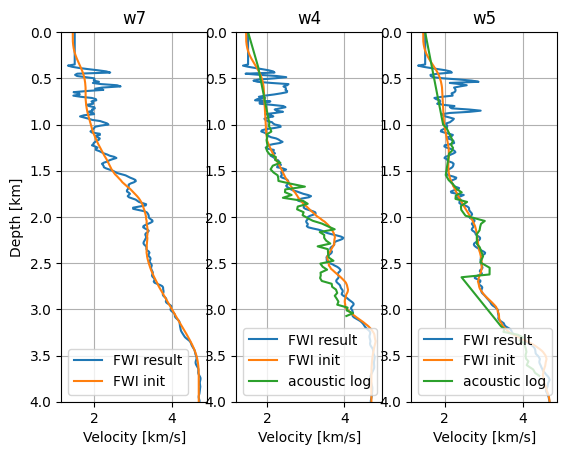

In [12]:
itp = LinearInterpolation((x, z), v)
itp0 = LinearInterpolation((x0, z0), v0)

w7_v = itp(w7_cdp_x/1000f0, z)
w4_v = itp(w4_cdp_x/1000f0, z)
w5_v = itp(w5_cdp_x/1000f0, z)

w7_v0 = itp0(w7_cdp_x/1000f0, z0)
w4_v0 = itp0(w4_cdp_x/1000f0, z0)
w5_v0 = itp0(w5_cdp_x/1000f0, z0)

figure()
subplot(131)
title("w7")
plot(w7_v, z, label="FWI result")
plot(w7_v0, z0, label="FWI init")
gca().set_xlabel("Velocity [km/s]")
gca().set_ylabel("Depth [km]")
gca().set_ylim(0,4)
gca().invert_yaxis()
gca().legend(loc="lower left")
gca().grid()
subplot(132)
title("w4")
plot(w4_v, z, label="FWI result")
plot(w4_v0, z0, label="FWI init")
plot(w4_blk[:,2]./1000f0, w4_blk[:,1]./1000f0, label="acoustic log")
gca().set_xlabel("Velocity [km/s]")
gca().set_ylim(0,4)
gca().invert_yaxis()
gca().legend(loc="lower left")
gca().grid()
subplot(133)
title("w5")
plot(w5_v, z, label="FWI result")
plot(w5_v0, z0, label="FWI init")
plot(w5_blk[:,2]./1000f0, w5_blk[:,1]./1000f0, label="acoustic log")
gca().set_xlabel("Velocity [km/s]")
gca().set_ylim(0,4)
gca().invert_yaxis()
gca().legend(loc="lower left")
gca().grid()
gcf()